# 신용대출 심사

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다. 

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


* 여러분이 작성한 예측 모델에 대한 중요 요인 보고서로
    * 고객은 모델의 성능에 대해 신뢰를 갖게 되었습니다.
    * 현장 전문가들이 가지고 있는 직관과 대체로 일치하기도 했지만,
    * 생각지 못했던 변수가 중요하게 작용함을 알게 된 것은, 고객에게 신선한 충격이 되었습니다.

* 이제 운영 시스템에 배포하고 베타 오픈을 하였습니다.
    * 대출창구에서는 대출심사결과를 기다려야 하는 번거로움이 사라져서 환영하는 분위기 입니다.
    * 그런데 한가지 문제가 발생했습니다. 신용평가가 낮게 나온 고객 한 명이 강한 불만을 제기하였습니다. 자신의 대출신청이 왜 반려되었는지 이해할수 없다는 것이었습니다.
    * 현장 직원은 인공지능이 그렇게 판단했다고 이야기 하는 것이 적절한 답변이 아니라고 판단하여, 제대로 된 답변을 하지 못했습니다.

* 고객사는 다시 여러분에게 요청을 해 왔습니다. **개별 신용평가 결과에 대한 근거를 제시**해 달라는 것입니다. 


## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

import shap

### 2) 데이터 로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|



* 데이터의 크기를 살펴봅시다.

In [4]:
data.shape

(1000, 17)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


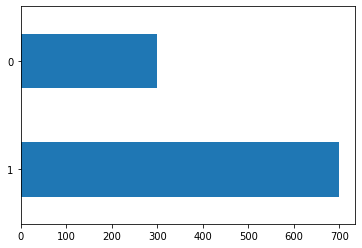

In [5]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts()/ data.shape[0])

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기 

In [6]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [7]:
dummy_vars = ['Employment', 'CurrentAddress', 'CreditCount', 'Dependents', 'Telephone', 'AccountBalance', 'Payment', 'Purpose', 'SexMarital', 'MostValuableAsset', 'Apartment','Occupation','ForeignWorker']


x = pd.get_dummies(x, columns = dummy_vars)
x.head()

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,24,1249,28,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1,9,276,22,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,18,1049,21,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,24,6419,44,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
4,12,1424,55,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0


### 3) train : validation 분할

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)

In [10]:
y_val.value_counts()

1    140
0     60
Name: Creditability, dtype: int64

## 3.모델링
* 종합실습1에서 성능이 가장 좋았던 모델을 다시 생성합시다.
* SVM은 SHAP value를 구하는 시간이 많이 소요되므로 지양해 주세요.

In [73]:
model = XGBClassifier()
model.fit(x, y)

XGBClassifier()

In [70]:
model = DecisionTreeClassifier()
model.fit(x,y)

DecisionTreeClassifier()

In [76]:
model = RandomForestClassifier()
model.fit(x,y)

RandomForestClassifier()

In [77]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

In [78]:
explainer.expected_value

array([0.30091, 0.69909])

## 4.개별 고객의 신용평가 예측 결과에 미치는 영향
* 모델을 생성한 후, validation 데이터를 운영에서 발생된 데이터로 간주하고 분석해 봅시다. 
* 최근 신용 대출 신청자중 인덱스 932, 741, 917, 226, 180 고객을 대상으로, 예측결과에 영향을 준 변수에 대해 설명하시오.


In [79]:
x.shape

(1000, 54)

In [80]:
np.array(x)[index:index+1, :]

array([[  24, 8648,   27,    0,    1,    0,    0,    0,    0,    1,    0,
           0,    0,    1,    0,    0,    1,    0,    0,    1,    0,    0,
           1,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    0,    0,    0,    1,    0,    0,    0,    1,
           0,    0,    1,    0,    0,    0,    1,    0,    1,    0]])

In [81]:
explainer.expected_value

array([0.30091, 0.69909])

In [92]:
shap.initjs()
index = 932
display(pd.DataFrame(np.array(x)[index:index+1, :], columns = list(x)))
shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], x.iloc[index,:])

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,24,8648,27,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0


In [85]:
shap.initjs()
index = 741
display(pd.DataFrame(np.array(x)[index:index+1, :], columns = list(x)))
shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], x.iloc[index,:])

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,12,697,46,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0


In [86]:
shap.initjs()
index = 917
display(pd.DataFrame(np.array(x)[index:index+1, :], columns = list(x)))
shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], x.iloc[index,:])

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,36,10477,42,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0


In [87]:
shap.initjs()
index = 226
display(pd.DataFrame(np.array(x)[index:index+1, :], columns = list(x)))
shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], x.iloc[index,:])

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,6,518,29,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0


In [90]:
shap.initjs()
index = 180
display(pd.DataFrame(np.array(x)[index:index+1, :], columns = list(x)))
shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], x.iloc[index,:])

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,18,2389,27,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0


## 5.추가 분석
* 모델의 전체 중요도와 유사도로 정렬한 후 force_plot 결과와 비교해 봅시다.

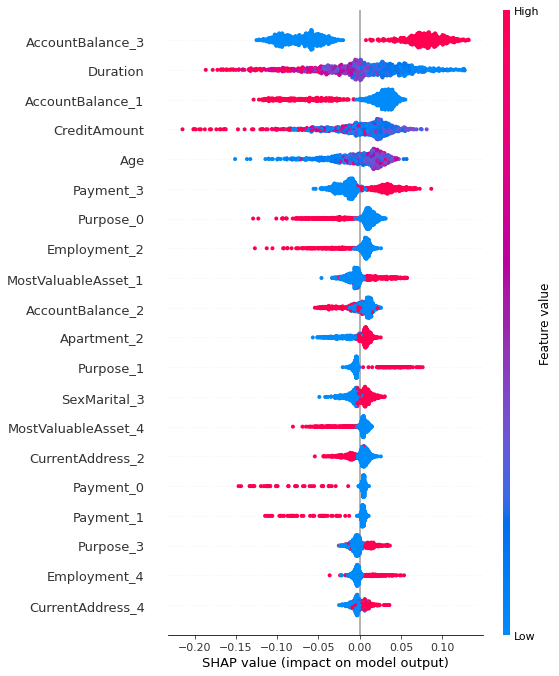

In [93]:
shap.summary_plot(shap_values[1], x)

In [36]:
x_temp = x.sample(200)
x_temp

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
612,42,9283,55,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
794,18,3049,45,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
190,6,1068,28,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
448,6,428,49,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,1,0
411,15,1360,31,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,12,763,26,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
199,18,1887,28,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
401,12,1884,39,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0
923,36,3990,29,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0


In [42]:
x.shape

(1000, 54)

In [37]:
x_temp.index

Int64Index([612, 794, 190, 448, 411, 732, 303, 312, 257,  49,
            ...
            805, 894, 803, 849, 998, 765, 199, 401, 923, 654],
           dtype='int64', length=200)

In [40]:
shap_values[1]

array([ 8.0447358e-01,  5.2684712e-01, -3.3054397e-01, -5.1609119e-03,
        6.5213829e-02, -3.9369875e-04, -3.1600945e-02, -1.4973533e-03,
       -3.9526722e-03,  7.6276645e-02,  0.0000000e+00, -2.4426416e-03,
        6.6641584e-02, -4.8160166e-02,  0.0000000e+00,  0.0000000e+00,
        2.2751821e-02,  0.0000000e+00, -5.2172583e-02,  0.0000000e+00,
        1.1584593e-01, -1.3393005e-03, -2.7939385e-01,  2.7459111e-02,
        2.3980638e-02,  2.6958449e-02, -1.0251457e-01, -4.0868863e-01,
       -8.5724898e-02,  1.0102061e-03, -1.2369938e-02,  0.0000000e+00,
        2.2923533e-04,  2.1684496e-02, -2.6660907e-04,  6.3581229e-03,
        0.0000000e+00,  1.2044566e-02,  1.7187832e-02, -6.2013394e-03,
       -9.5856776e-03,  3.1211072e-01, -5.6961542e-03,  6.7692727e-04,
        2.9941104e-02, -1.0779427e-01, -7.5065270e-02,  5.5439831e-03,
       -1.5064314e-03, -1.8378325e-03,  8.5893748e-03,  1.5450436e-02,
       -1.5123518e-02,  0.0000000e+00], dtype=float32)

In [41]:
shap_values

array([[-0.24602059, -0.20318635, -0.10469803, ...,  0.0301823 ,
        -0.0193394 ,  0.        ],
       [ 0.8044736 ,  0.5268471 , -0.33054397, ...,  0.01545044,
        -0.01512352,  0.        ],
       [-0.12336466, -0.21027358, -0.24277413, ..., -0.02268524,
        -0.01978979,  0.        ],
       ...,
       [-0.55239266, -0.67128664, -0.04010134, ...,  0.02075034,
        -0.00847948,  0.        ],
       [ 0.47780854,  0.10326707,  0.11649854, ...,  0.05917453,
        -0.01025143,  0.        ],
       [ 0.25496078, -0.06936672, -0.12770891, ...,  0.0335193 ,
        -0.01572239,  0.        ]], dtype=float32)

In [34]:
x_temp = x.sample(200)
sv_temp = shap_values[1][x_temp.index]

IndexError: ignored

* 예측값(Output value)으로 정렬한 그래프를 보며, 신용도 높은 사람과 낮은 사람의 전반적인 특징이 어떻게 달라지는지 확인해 봅시다.

* 두 feature의 조합과 shap value 간의 관계 그래프 dependence_plot을 그려보고 관계를 설명해 봅시다.
(최소 조합 2개 이상)